# Monochrome camera calibration
One of the great disadvantages with using lenses is the distortion it introduces to the image. For vacation images, this is usually not a problem, but when we use the image to describe the physical surroundings it becomes important that the images are representative of the scene it captures. An easy way to get an indication of how distorted an image is by looking at what is supposed to be straight lines since they will appear curved. The following exercises you will be calibrating a camera to obtain a camera matrix such that you can undistort images from this camera.

## Exercise 1
The process of calibrating an image consists of mainly 3 steps: 1) find chessboard-corners in a dataset of images containing a chessboard. 2) Use the corner points to compute a camera matrix. 3) Use the camera matrix to undistort images.

After setting some optimization parameters we can loop over all the images in the `imgs` folder and extract the checkerboard corners.

Use any of the images in the folder `imgs` to extract the number of checkerboard corners there are on the checkerboard. Fill in the information in `nb_vertical` and `nb_horizontal` and look up the opencv [findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) function and implement it in the below code snippet .

with pattern ( 13 , 3 ) total 1
with pattern ( 11 , 7 ) total 1
with pattern ( 11 , 7 ) total 2
with pattern ( 7 , 5 ) total 1
with pattern ( 7 , 5 ) total 2
with pattern ( 7 , 5 ) total 3
with pattern ( 7 , 5 ) total 4
with pattern ( 7 , 5 ) total 5
with pattern ( 7 , 5 ) total 6
with pattern ( 7 , 5 ) total 7
with pattern ( 6 , 5 ) total 1
with pattern ( 6 , 5 ) total 2
with pattern ( 6 , 5 ) total 3


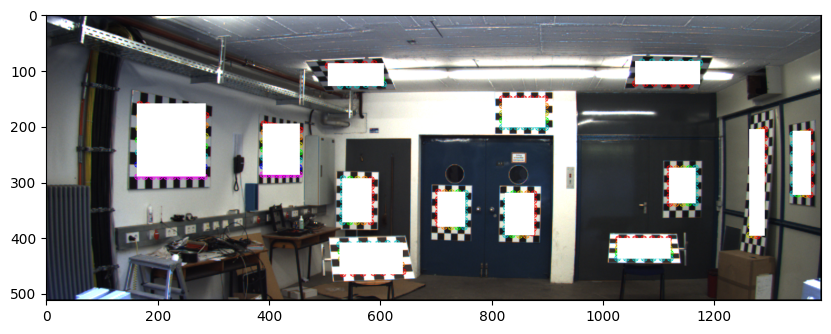

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Define number of inner corners per chessboard pattern
#patterns = [(5,7), (6,7), (8,8)]
from itertools import product

# Define the range
range_vals = range(3, 15)

# Generate all unique combinations of two-element tuples
patterns = list(product(range_vals, repeat=2))

patterns.sort(reverse=True)


# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in image plane

# Load images
images = glob.glob('/Users/wangdepei/Documents/perception_autonomous/final_project/34759_final_project_raw/calib/image_02/data/0000000000.png')
assert images, "No images found in the specified directory."

img = cv2.imread(images[0])
img_copy = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for nb_vertical, nb_horizontal in patterns:
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ....,(6,5,0) for each chessboard
    objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

    
    
    chessboards_detected = 0  # Counter for detected chessboards in the image

    # Continue detecting chessboards until all 13 are found or no more can be detected
    while chessboards_detected < 13:
        # Detect chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal), None)

        if ret:
            # Add object points, image points
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw the chessboard corners on the image for visualization/masking
            img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)

            # Calculate the bounding rectangle for the chessboard
            corners_int = np.squeeze(corners).astype(int)
            upper_left = tuple(corners_int.min(axis=0))
            lower_right = tuple(corners_int.max(axis=0))

            # Paint over the detected chessboard area with a solid color (e.g., white)
            cv2.rectangle(img, upper_left, lower_right, (255, 255, 255), thickness=-1)

            # Update the grayscale version of the image with the masked area
            cv2.rectangle(gray, upper_left, lower_right, 255, thickness=-1)

            chessboards_detected += 1
            print("with pattern (", nb_vertical, ",", nb_horizontal, ") total", chessboards_detected)
        else:
            # Break if no more chessboards are detected
            break

# Display the modified image with all chessboards masked out
plt.figure(figsize=(10,10))
plt.imshow(img[...,[2,1,0]])



Using the extracted corners we can obtain a camera matrix that contains the information needed to undistort images

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
h,  w = img.shape[:2]
alpha = 0.1
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),alpha,(w,h))

The last step is to actually undistort an image:

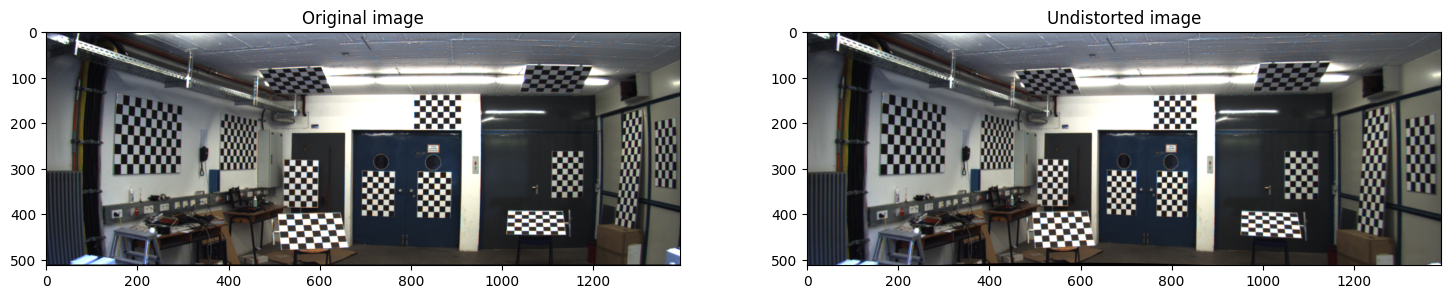

In [5]:
# undistort
dst = cv2.undistort(img_copy, mtx, dist, None, newcameramtx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img_copy[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

# Display the undistorted image 
cv2.imshow('Undistorted Image', dst)
cv2.waitKey(10000)  # Display each image for 1 second
cv2.destroyAllWindows()

A refining step can be to crop the image such that it doesn't contain the large black areas at the edges of the image.

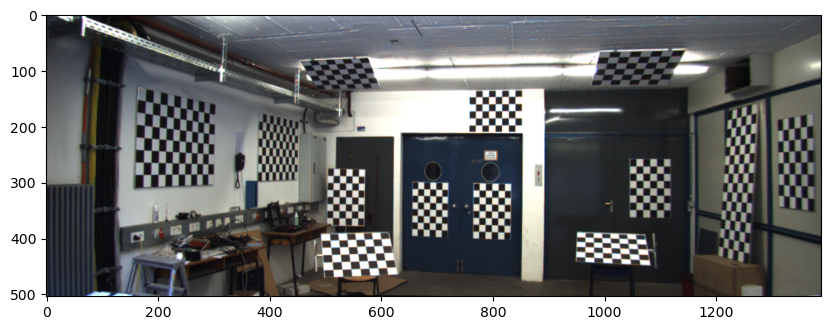

In [4]:
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst[...,[2,1,0]])

In [5]:
# Provided calibration values
K_00 = np.array([[9.812178e+02, 0.000000e+00, 6.900000e+02],
                 [0.000000e+00, 9.758994e+02, 2.471364e+02],
                 [0.000000e+00, 0.000000e+00, 1.000000e+00]])
D_00 = np.array([-3.791375e-01, 2.148119e-01, 1.227094e-03, 2.343833e-03, -7.910379e-02])
S_00 = (1392, 512)
R_00 = np.array([[1.000000e+00, 0.000000e+00, 0.000000e+00],
                 [0.000000e+00, 1.000000e+00, 0.000000e+00],
                 [0.000000e+00, 0.000000e+00, 1.000000e+00]])
T_00 = np.array([-7.686159e-17, -2.989062e-17, -1.366428e-16])
S_rect_00 = (1224, 370)
R_rect_00 = np.array([[9.999128e-01, 1.009263e-02, -8.511932e-03],
                      [-1.012729e-02, 9.999406e-01, -4.037671e-03],
                      [8.470675e-03, 4.123522e-03, 9.999556e-01]])
P_rect_00 = np.array([[7.070493e+02, 0.000000e+00, 6.040814e+02, 0.000000e+00],
                      [0.000000e+00, 7.070493e+02, 1.805066e+02, 0.000000e+00],
                      [0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00]])

print("\n--- Camera Matrix (K_00) Comparison ---")
print(newcameramtx)
print("Difference (newcameramtx - K_00):\n", newcameramtx - K_00)

print("\n--- Distortion Coefficients (D_00) Comparison ---")
print("Difference (dist - D_00):\n", dist.ravel() - D_00)

print("\n--- Image Size (S_00) Comparison ---")
original_size = (dst.shape[1], dst.shape[0])
print("Difference (Original Size - S_00):\n", (original_size[0] - S_00[0], original_size[1] - S_00[1]))

print("\n--- Rotation Matrix (R_00) Comparison ---")
rotation_matrix, _ = cv2.Rodrigues(rvecs[0])
print("Difference (rotation_matrix - R_00):\n", rotation_matrix - R_00)

print("\n--- Translation Vector (T_00) Comparison ---")
print("Difference (tvecs[0] - T_00):\n", tvecs[0].ravel() - T_00)

print("\n--- Rectified Image Size (S_rect_00) Comparison ---")
rectified_size = (dst.shape[1], dst.shape[0])
print("Difference (Rectified Size - S_rect_00):\n", (rectified_size[0] - S_rect_00[0], rectified_size[1] - S_rect_00[1]))

print("\n--- Rectification Rotation Matrix (R_rect_00) Comparison ---")
identity_matrix = np.eye(3)
print("Difference (Identity - R_rect_00):\n", identity_matrix - R_rect_00)

print("\n--- Projection Matrix (P_rect_00) Comparison ---")
print("Difference (newcameramtx - P_rect_00[:,:3]):\n", newcameramtx - P_rect_00[:, :3])





--- Camera Matrix (K_00) Comparison ---
[[1.01740682e+03 0.00000000e+00 6.55939303e+02]
 [0.00000000e+00 1.06425472e+03 2.54201920e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Difference (newcameramtx - K_00):
 [[ 36.18901874   0.         -34.06069655]
 [  0.          88.35532148   7.06551997]
 [  0.           0.           0.        ]]

--- Distortion Coefficients (D_00) Comparison ---
Difference (dist - D_00):
 [ 0.2303206  -0.60333767 -0.00312161 -0.01945685  0.56491849]

--- Image Size (S_00) Comparison ---
Difference (Original Size - S_00):
 (-3, -8)

--- Rotation Matrix (R_00) Comparison ---
Difference (rotation_matrix - R_00):
 [[-1.09090687  0.02292276  0.99559554]
 [ 0.99482222 -0.95229392  0.08973787]
 [-0.04543892  0.99859836 -1.02714088]]

--- Translation Vector (T_00) Comparison ---
Difference (tvecs[0] - T_00):
 [36.48194594 -2.98825328 61.89752647]

--- Rectified Image Size (S_rect_00) Comparison ---
Difference (Rectified Size - S_rect_00):
 (165, 134)

--- Rect